# Algorithms Project: The Big Heist
by Pavel Borovikov

> #### Objective:
> Using the provided data from *bank_data.csv*, **aquire as much money as possible** from the banks in **under 24 hours**. The time to rob and money earned is available in the provided data. The hypothetical car that will be used during the heist travels at a speed of 30*km/h*. The car can start at any bank, but must end it's travels at the point of origin (0,0).

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
df = pd.read_csv('data/bank_data.csv')
print("Total money available: ", df['money'].sum())
print("Total time to rob all the banks: ", df['time (hr)'].sum())
df.describe()

Total money available:  184303200
Total time to rob all the banks:  7502.450028524693


,id,x_coordinate,y_coordinate,money,time (hr)
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,-0.016431,0.037561,18430.320000,0.750245
std,2886.89568,2.889568,2.881789,25382.131155,0.433541
min,0.00000,-4.999292,-4.999928,100.000000,0.000032
25%,2499.75000,-2.513854,-2.415033,900.000000,0.373141
50%,4999.50000,-0.024904,0.010442,5800.000000,0.749218
75%,7499.25000,2.461754,2.540303,26900.000000,1.122812
max,9999.00000,4.999851,4.999626,102300.000000,1.499851


The data provided contains a unique id for each of the 10 000 banks, which will later be used to create a route.

<br>

#### Columns :

    id : unique intiger id for the bank
    x_coordinate, y_coordinate : x and y coordinates of the bank
    money : total gains from the bank
    time (hr) : total time necessary to rob the bank

<br>

#### Things to note:

- The minimum and maximum of the x and y coordinates show that the banks spread around an area of about $100km^{2}$.

- There are big differences between the minimum amounts of money and time compared to their respective maximum.

- The total amount of gains possible is 184 303 200$, the time it would take to rob that is 7 502.45 hours


<br>

> Due to there being only 24 hours available for the heist, it would be impossible to rob all of the banks. The banks must go through some selection process in order to obtain as much money as possible within 24 hours.
>
> **To get a better understanding of the data, the following columns will be added:**<br><br>
> > **day percent** : the percentage of the total 24h that it would take to rob the bank.<br><br>
> > **score** : the score dividing the money gained per hour by the percentage of the day that it will take.

In [53]:
df['day percent'] = (df['time (hr)'] / 24) * 100
df['score'] = df['money'] / df['day percent']
print("Minimum score : ", df['score'].min())
print("Maximum score : ", df['score'].max())

Minimum score :  16.00409676564774
Maximum score :  70310476.15889467


Due to the big difference in score, a logarithm is applied to achieve a smaller range.

In [54]:
df['score'] = np.log(df['score'])
print("Minimum score : ", df['score'].min())
print("Maximum score : ", df['score'].max())

Minimum score :  2.772844737318108
Maximum score :  18.06843136643082


The values of the scores are arbitrary, however, the higher the score, the more worthy a bank is.
Because the score takes into account what percentage of the day a bank will take to rob, the score will favor really small robbing times with high monetary gains. 

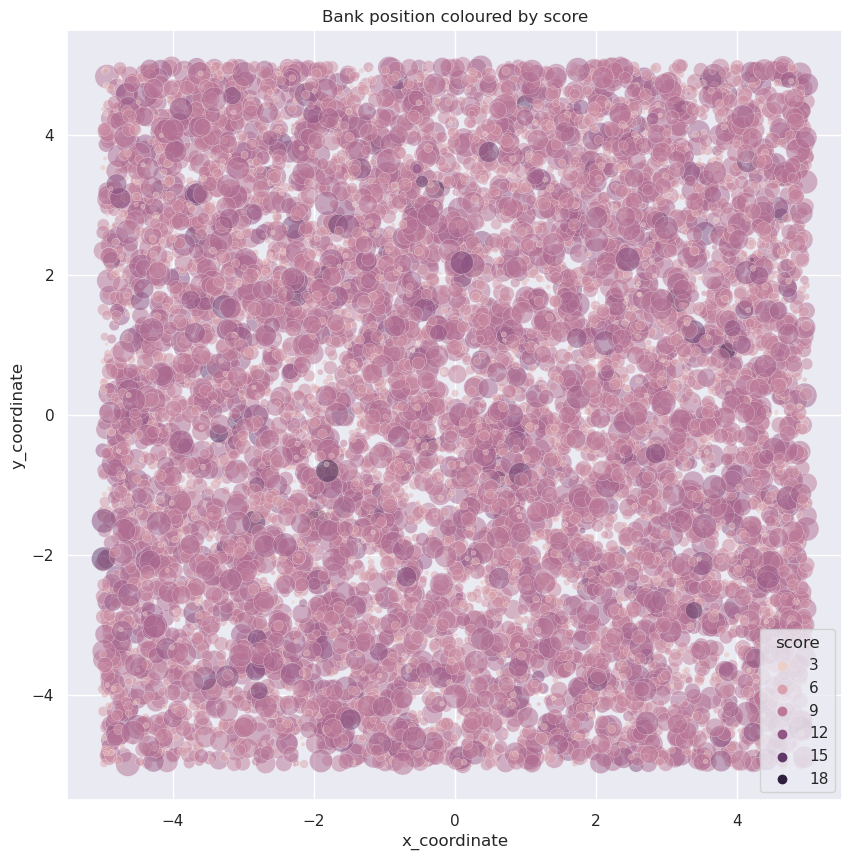

In [61]:
sns.scatterplot(x=df['x_coordinate'], y=df['y_coordinate'], hue=df['score'], s=np.sqrt(df['money']), alpha=0.5);
plt.title('Bank position coloured by score');
sns.set(rc={'figure.figsize':(10, 10)});

The scatter plot above shows the positions of the banks with a circle.<br>
The gradiant of color represents the score of the bank.<br>
The size of each circle represent squareroot of the total gains from the bank, relative to eachother. The squareroot was applied in order to bring the large size diffence down.

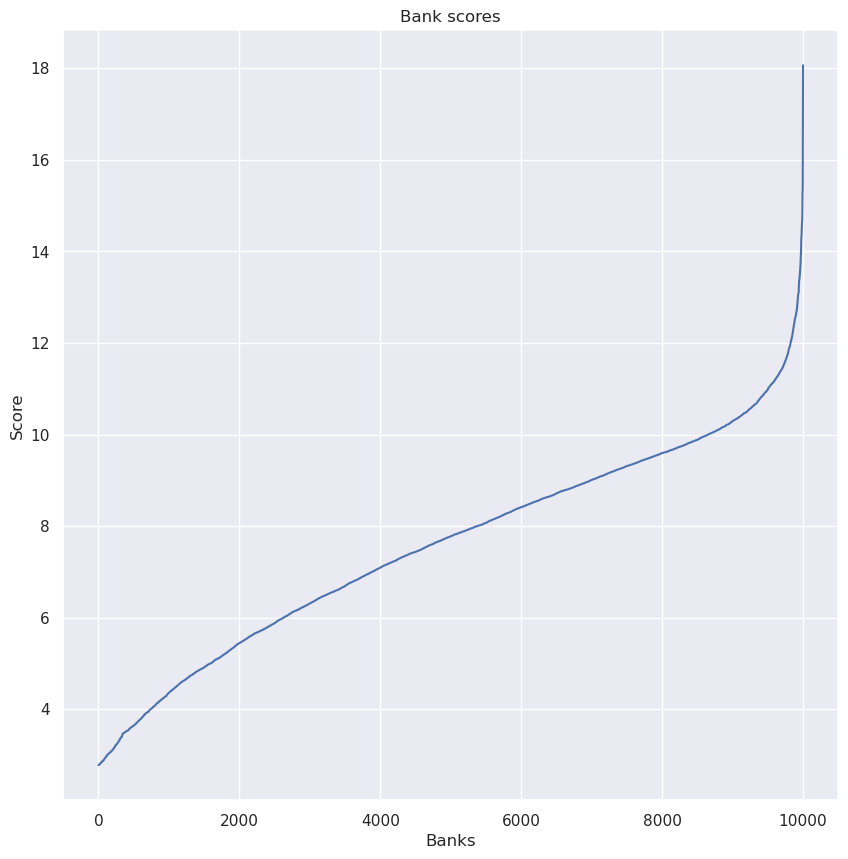

In [64]:
sorted_scores = df['score'].sort_values()
x = np.arange(len(df['score']))

plt.plot(x, sorted_scores)
plt.title('Bank scores')
plt.xlabel('Banks')
plt.ylabel('Score')
plt.show()

According to the graph above, a small amount of banks have a significantly higher score than others.

Total money: 9167200
Time to rob:  6.498374831828951
Total amount banks:  178


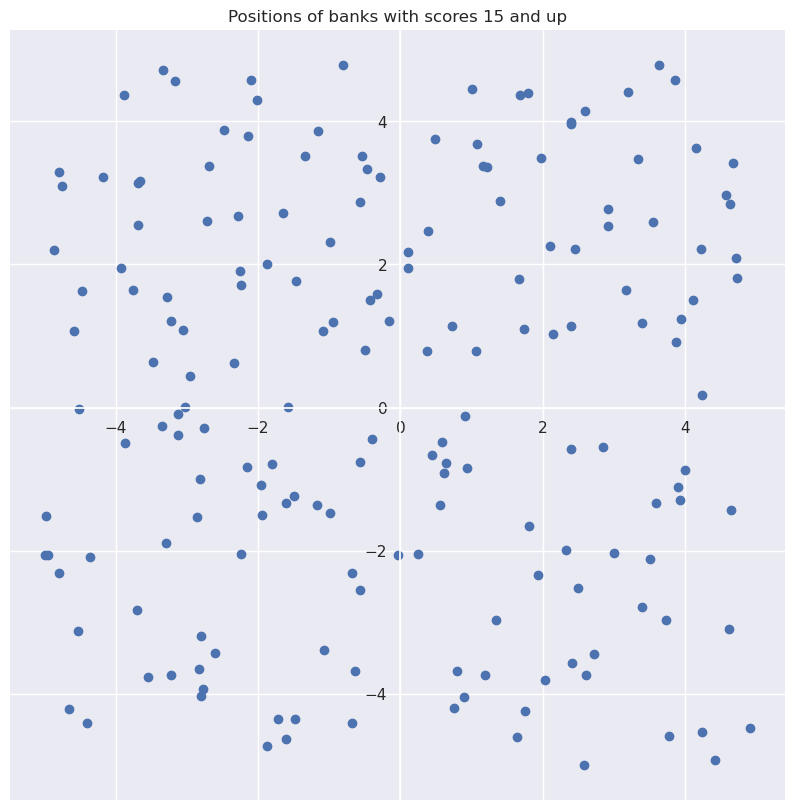

In [65]:
best = df.loc[(df['score'] >= 12)]

fig, ax = plt.subplots()
ax.set_title('Positions of banks with scores 15 and up')

ax.scatter(best['x_coordinate'], best['y_coordinate'], label='15 and up')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

print('Total money:', best['money'].sum())
print('Time to rob: ', best['time (hr)'].sum())
print('Total amount banks: ', len(best))
plt.show()

The first approach to this problem will be applying a nearest neighbour algorithm of best case complexity $O(n^{2})$